In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import fftpack

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# データ ファイルのパス
PATH = 'Q4149CF2.csv'

In [3]:
# オリジナルの加速度を読み込む。
data = pd.read_csv(PATH, skiprows=6)
data = data.rename(columns={' NS': 'NS'})
print(data.head())

    NS     EW     UD
0  0.0  0.001 -0.002
1  0.0  0.001 -0.000
2  0.0 -0.000 -0.000
3  0.0 -0.003 -0.001
4  0.0 -0.004 -0.002


/Users/yoshimutamasayuki/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


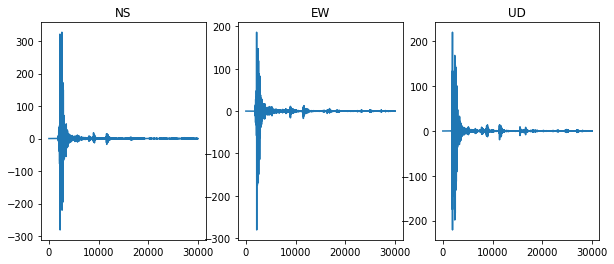

In [4]:
# オリジナルの加速度の波形を描画する。
fig, (ax_NS, ax_EW, ax_UD) = plt.subplots(ncols=3, figsize=(10,4))

ax_NS.plot(data['NS'])
ax_NS.set_title('NS')

ax_EW.plot(data['EW'])
ax_EW.set_title('EW')

ax_UD.plot(data['UD'])
ax_UD.set_title('UD')


fig.show()

In [5]:
# 1. データをフーリエ変換する。
fft_df = pd.concat([pd.Series(fftpack.fft(data[column])) for column in data.columns], axis=1)

fft_df = fft_df.rename(columns={0: 'NS', 1: 'EW', 2: 'UD'})
fft_df.head()

,NS,EW,UD
0,(-338.5949999999998+0j),(636.0120000000005+0j),(-423.8810000000001+0j)
1,(-102.11553062609994+93.90802104823506j),(380.5350355333907-404.23625229078175j),(13.063347437296029-11.982666888421406j)
2,(-14.043614482692934+128.9469561501915j),(7.487425681622943-483.17162374075474j),(0.5305600051322676-8.46160624027443j)
3,(60.21924017268797+103.64617426272724j),(-247.5525548271849-316.6688788639158j),(-1.2284714480724483+7.02888174724717j)
4,(100.2780726078649+49.97043538209756j),(-318.2583086332212-95.48705348406887j),(9.070095197017691+17.71923610529572j)


In [6]:
# フィルターをかける。(図3を参照)
def filter_1(f):
    """周期の効果を表すフィルターです。
    """
    return np.sqrt(1 / f)


def filter_high(f):
    """ハイカットフィルターです。
    """
    y = f * 0.1
    result = (1 + 0.694 * y ** 2 + 0.0557 * y ** 6 + 0.009664 * y ** 8
              + 0.00134 * y ** 10 + 0.000155 * y ** 12)
    return 1 / np.sqrt(result)


def filter_low(f):
    """ローカットフィルターです。
    """
    return np.sqrt(1 - np.exp(- (f / 0.5) ** 3))


filtered_df = filter_low(filter_high(filter_1(fft_df)))

filtered_df.head()

,NS,EW,UD
0,(0.9998322958744803+0j),(0.9998322326490748+0j),(0.9998322875739679+0j)
1,(0.9998323287410882+6.814456770546121e-08j),(0.9998322373676326-1.8325092436309123e-08j),(0.9998316736905706-5.342148373920197e-07j)
2,(0.9998322663052701+1.0707095694318602e-07j),(0.9998322541707895-2.8908325821624163e-08j),(0.9998321578551023-1.6454288323054775e-06j)
3,(0.9998321960809226+1.0080403079693841e-07j),(0.9998322760245586-2.738113781569563e-08j),(0.9998326002136492+1.9256554809285128e-06j)
4,(0.9998321429867012+5.564564943901541e-08j),(0.9998322948863376-1.2080821739480795e-08j),(0.9998319354938039+6.257078718357155e-07j)


In [7]:
# 逆フーリエ変換する。
# 逆フーリエ変換すると、虚部が残る可能性があるので、np.real をかぶせる。
ifft_df = pd.concat([pd.Series(np.real(fftpack.ifft(filtered_df[column]))) for column in filtered_df.columns], axis=1)

ifft_df = ifft_df.rename(columns={0: 'NS', 1: 'EW', 2: 'UD'})
ifft_df.head(14)

,NS,EW,UD
0,0.999860,1.465772e+16,221.863779
1,0.000498,-1.170095e+16,-73.018946
2,-0.000723,1.383406e+15,-223.432001
3,0.000532,9.804402e+15,51.972015
4,-0.000067,-1.482450e+16,232.430595
5,-0.000395,1.051888e+16,-39.758572
6,0.000603,4.039061e+14,-230.805260
7,-0.000468,-1.107261e+16,19.084335
8,0.000124,1.477582e+16,233.915066
9,0.000163,-9.183936e+15,-1.306034


In [27]:
# フィルター処理済みの3成分波形をベクトル的に合成する。

def synthesize_vector(x, y, z):
    return np.sqrt(x ** 2 + y ** 2 + z ** 2)

a = []
for row in ifft_df.iterrows():
    a.append(synthesize_vector(row[1]['NS'], row[1]['EW'], row[1]['UD']))

# ベクトル合成の結果
synthesized_series = pd.Series(a)

In [204]:
# 6. 計測震度 I を計算する。

In [190]:
# Iの小数第３位を四捨五入し、小数第２位を切り捨てたものを計測震度として返す。